# TOP TAGGING COMPARISON ANALYSIS

In [3]:
# import sys
# sys.path.append("..")

import numpy as np
np.seterr(divide="ignore")
# import logging
import pickle
# import glob
import pandas as pd
# import os
import scipy as sp
# import json

import itertools

# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import roc_auc_score

from scipy import interp

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)


import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import sklearn.metrics as metrics

# import h5py

rcParams.update({'figure.autolayout': True})
# plt.rc('font', family='serif')

# Switch to true if results change (e.g. new taggers are added)
# save_results=True
save_results=False

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = "serif"
# plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

# ALIGN DATA OF ALL TAGGERS

In [5]:
def load_array(sample):
    
    
    #Update path
    path = "outputs_allTaggers/"
    
    names = {

         "ParticleNet" : ["P-CNN_ResNeXt_ParticleNet_9runs/ParticleNet_v2_run{0}.npy".format(i) for i in range(9)],
         "TreeNiN"  : "TreeNiN_hd50.npy",
         "ResNeXt"  : ["P-CNN_ResNeXt_ParticleNet_9runs/ResNeXt-50_v2_run{0}.npy".format(i) for i in range(9)],
         "PFN"      : "PFN_model_outputs.npy",
         "CNN" :      "RutgersCNN_9runs.npy",
         "NSub(8)"  : "8_body_v2_test_sets.npy",
         "LBN"      : "lbn_ensemble9.npz",
         "NSub(6)"  : "6_body_test_sets.npy",
         "P-CNN"    : ["P-CNN_ResNeXt_ParticleNet_9runs/P-CNN_v2_run{0}.npy".format(i) for i in range(9)],
         "LoLa"     : "LoLa_average_clf_matrix.npy",
         "EFN"      : "EFN_model_outputs.npy",
         "EFP"      : "EFP_v0.npy",
         "TopoDNN"  : ["topodnn_9runs/topodnn_{0}.npy".format(i) for i in range(1,10)],
         "nsub+m-old"   : "sd_nsub2_nsub3_pt.npy", # This is the old version. There is a bug with this version
         "nsub+m": "m_nsub_test.npy",  # I renamed the new version nsub+m-v2 as nsub+m
        }
    
    if type(names[sample]) is str:
#         print("String")
        fn = path + names[sample]
        events = np.load(fn)
        
        if sample == 'LBN':
            events = events["outputs"]
            events = np.swapaxes(events,0,1)
            events = 1.-events
    else:
        all_events = []
        for fn in names[sample]:
            fn = path + fn
            all_events.append(np.load(fn))
    
        events = np.stack(all_events,axis=0)
        
    # nsub 6/8 sent 10 taggers not 9. Drop the last one
    # also swap dimensions
    # and invert order
    if sample in ["NSub(6)","NSub(8)"]:
        events = events[:,:9]
        events = np.swapaxes(events,0,1)
        events = events[:,::-1]

    # Only have one copy of nsub+m
    # duplicate 9 times
    # also invert order
    if sample in ["nsub+m-old","nsub+m"]:
        events = events[::-1]
        events = np.expand_dims(events,0)
        events = np.repeat(events,9,axis=0)
        
    # Only have one copy of EFP
    # duplicate 9 times
    if sample in ["EFP"]:
        events = np.expand_dims(events,0)
        events = np.repeat(events,9,axis=0)
        
        
    return events

In [6]:
# Load labels
with open('labels.pkl', "rb") as f: truth=np.asarray(pickle.load(f),dtype=int)

In [7]:
np.shape(truth)

(404000,)

In [8]:
# Checl load_array
ret = load_array("NSub(6)")
print(ret.shape)
for i in range(len(ret)):
    print(metrics.roc_auc_score(truth,ret[i]))

(9, 404000)
0.9788619251583864
0.9789858950735143
0.9787907501381332
0.9790209223811083
0.9788626575499514
0.9788940456180855
0.9153889601930386
0.9789230543724857
0.9791283091273644


In [9]:
# Checl load_array
ret = load_array("nsub+m")
print(ret.shape)
metrics.roc_auc_score(truth,ret[1])

(9, 404000)


0.9670978807753143

In [10]:
# Make a dictionary with all tagger output probabilities
def load_allTaggers():
    
    names= ['ParticleNet',  'TreeNiN', 'ResNeXt',  'PFN', 'CNN', 'NSub(8)','LBN', 'NSub(6)',  'P-CNN', 'LoLa', 'EFN', 'nsub+m', 'EFP', 'TopoDNN']
    taggers_dic={}
    taggers_dic['names']=names
    taggers_dic['out_prob']=[]
    
    
    for name in names:
         taggers_dic['out_prob'].append(load_array(name))
            
    return taggers_dic

In [11]:
#Load all taggers
taggers_dict = load_allTaggers()

In [12]:
taggers_dict['names']

['ParticleNet',
 'TreeNiN',
 'ResNeXt',
 'PFN',
 'CNN',
 'NSub(8)',
 'LBN',
 'NSub(6)',
 'P-CNN',
 'LoLa',
 'EFN',
 'nsub+m',
 'EFP',
 'TopoDNN']

In [13]:
np.shape(np.asarray(taggers_dict['out_prob']))

(14, 9, 404000)

# ROC curves, AUC, accuracy and background rejection

### Calculate the accuracy

In [14]:
# compute the accuracy    
def get_accuracy(outputs, labels):

    # Flatten array
    labels = labels.ravel()
        
    # Round elements of the array to the nearest integer.
    outputs=np.rint(outputs)

    outputs=np.asarray(outputs)
    labels=np.asarray(labels)
    
    outputs=outputs.flatten()

    return np.sum(outputs==labels)/float(len(labels))

### Get median background rejection of all models and std

In [15]:
# Get median model sorted by auc
def get_median_bg_reject(input_True_labels, input_taggers_dict, tag_eff=0.3, remove_outliers=False):

    #---------------------------------------
    #Get tag efficiency working point
    if tag_eff==0.5:
        point=225 #0.05 + 225*(1 - 0.05)/476=0.5
    elif tag_eff==0.3:
        point=125 #0.05 + 125*(1 - 0.05)/476=0.3
    elif tag_eff==0.4:
        point=175
    
    base_tpr = np.linspace(0.05, 1, 476)
    input_taggers_median=[]
    
    all_bg_reject=[]
    all_bg_reject_std=[]
    
    all_bg_reject_outliers=[]
    all_bg_reject_std_outliers=[]
    
    all_aucs=[]
    all_auc_std=[]
    all_aucs_outliers=[]
    all_auc_std_outliers=[]
    
    len_models=[]
    
    for k in range(len(input_taggers_dict['out_prob'])):
        
            out_probs=input_taggers_dict['out_prob'][k]

            bg_reject=[]
            bg_reject_std=[]
            aucs=[]
        
            for i in range(len(out_probs)):
                
                    auc=roc_auc_score(input_True_labels, out_probs[i])
                    aucs.append(auc)
                    
                    fpr, tpr, thresholds = roc_curve(input_True_labels, out_probs[i] ,pos_label=1, drop_intermediate=False)


                    interp_fpr = interp(base_tpr, tpr, fpr)

                    bg_reject.append(1./interp_fpr[point])
        
            
            all_bg_reject.append(np.median(bg_reject))
            all_bg_reject_std.append(np.std(bg_reject))

            all_aucs.append(np.median(aucs))
            all_auc_std.append(np.std(aucs))
            
            if remove_outliers:
                scores = np.asarray(bg_reject)
                
                p25 = np.percentile(scores, 1 / 6. * 100.)
                p75 = np.percentile(scores, 5 / 6. * 100)
                
                # Get mean and std for the bg rejection
                robust_mean = np.mean([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
                robust_std = np.std([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])


                indices = [i for i in range(len(scores)) if robust_mean - 3*robust_std <= scores[i] <= robust_mean + 3*robust_std]
    
                new_scores=scores[indices]
        
                len_models.append(len(new_scores))
    
                all_bg_reject_outliers.append(np.median(new_scores))
                all_bg_reject_std_outliers.append(np.std(new_scores))
            
                new_aucs=np.asarray(aucs)[indices]
                all_aucs_outliers.append(np.median(new_aucs))
                all_auc_std_outliers.append(np.std(new_aucs))

            
    if remove_outliers:
    
        return len_models, all_bg_reject_outliers, all_bg_reject_std_outliers, all_aucs_outliers, all_auc_std_outliers
    
    else:
                    
        return all_bg_reject, all_bg_reject_std, all_aucs, all_auc_std

In [16]:
taggers_dict['names']

['ParticleNet',
 'TreeNiN',
 'ResNeXt',
 'PFN',
 'CNN',
 'NSub(8)',
 'LBN',
 'NSub(6)',
 'P-CNN',
 'LoLa',
 'EFN',
 'nsub+m',
 'EFP',
 'TopoDNN']

In [58]:
median_bg_reject_withoutliers, bg_reject_std_withoutliers, aucs_withoutliers, auc_std_withoutliers = get_median_bg_reject(truth,taggers_dict, tag_eff=0.3)

In [18]:
get_median_bg_reject(truth,taggers_dict, tag_eff=0.3,remove_outliers=True)

([8, 6, 8, 8, 6, 7, 6, 7, 9, 8, 9, 9, 9, 7],
 [1298.4957402812242,
  1024.9441624365481,
  1122.298666007905,
  891.4568827726015,
  913.6380090497738,
  866.5836909871244,
  836.115072016461,
  791.8196078431372,
  731.572463768116,
  722.4322563301672,
  632.9592476489028,
  403.0219560878243,
  383.8669201520912,
  295.19590643274853],
 [46.15639800427593,
  10.83293262418181,
  47.36918503380577,
  18.248019553200532,
  14.497354587735504,
  14.694401619109543,
  17.27368354172959,
  17.880235292084976,
  23.694155191442974,
  17.27869997426598,
  31.3024973814917,
  0.0,
  0.0,
  4.8624576960181916],
 [0.9847665877875621,
  0.9823601702721747,
  0.9837246773999538,
  0.9818724001918506,
  0.9813976707042735,
  0.9808581661093764,
  0.981096055293266,
  0.9788940456180855,
  0.9802825331749243,
  0.9801924536198261,
  0.9788583913742932,
  0.9670978807753143,
  0.9803312707707597,
  0.9713277999323696],
 [6.071956714254019e-05,
  6.0433104077777926e-05,
  4.86796891966511e-05,
  0.

### Median model sorted by auc

In [19]:
# Get median model sorted by auc
def get_median_model(input_True_labels, input_taggers_dict):

    input_taggers_median=[]
    for k in range(len(input_taggers_dict['out_prob'])):
        
            out_probs=input_taggers_dict['out_prob'][k]
            aucs_tuple=[]

            for i in range(len(out_probs)):

                auc=roc_auc_score(input_True_labels, out_probs[i])
                aucs_tuple.append((i,auc))

            sorted_auc=sorted(aucs_tuple,key=lambda x: x[1])                

            median_model=sorted_auc[len(sorted_auc)//2]

            print('Median model (position,auc) =',median_model)

            # Choose median model
            input_taggers_median.append(input_taggers_dict['out_prob'][k][median_model[0]])
    
                    
    return input_taggers_median

In [20]:
taggers_dict['median']= get_median_model(truth,taggers_dict)     

Median model (position,auc) = (6, 0.9847607116897907)
Median model (position,auc) = (3, 0.9823518474162892)
Median model (position,auc) = (3, 0.9837151719575877)
Median model (position,auc) = (3, 0.9818809996444435)
Median model (position,auc) = (8, 0.981418680265968)
Median model (position,auc) = (8, 0.9808581661093764)
Median model (position,auc) = (4, 0.9810897679305932)
Median model (position,auc) = (5, 0.9788940456180855)
Median model (position,auc) = (1, 0.9802825331749243)
Median model (position,auc) = (4, 0.9802188900156579)
Median model (position,auc) = (2, 0.9788583913742932)
Median model (position,auc) = (4, 0.9670978807753143)
Median model (position,auc) = (4, 0.9803312707707597)
Median model (position,auc) = (1, 0.9714127204825134)


### Plot ROC curves, and get AUC, accuracy, err and background rejection

In [21]:
def plot_roc_all(input_True_labels,input_out_probs, tagger_names, show_all=False, tag_eff=0.3, show_plot=False,title='', plotName=None):
    
    bg_reject=[]
    aucs=[]
    errors=[]
    accuracies=[]
    base_tpr = np.linspace(0.05, 1, 476)
    
    #---------------------------------------
    #Get tag efficiency working point
    if tag_eff==0.5:
        point=225 #0.05 + 225*(1 - 0.05)/476=0.5
    elif tag_eff==0.3:
        point=125 #0.05 + 125*(1 - 0.05)/476=0.3
    elif tag_eff==0.4:
        point=175

    linestyles=['-','--','-.',':']*10    
        
    #---------------------------------------    

    
    for i in range(len(input_out_probs)):
            
            acc= get_accuracy(input_out_probs[i],input_True_labels)
            accuracies.append(acc)
            
            auc=roc_auc_score(input_True_labels, input_out_probs[i])
            aucs.append(auc)

            fpr, tpr, thresholds = roc_curve(input_True_labels, input_out_probs[i] ,pos_label=1, drop_intermediate=False)

            inv_fpr = interp(base_tpr, tpr, fpr)
    #         inv_fprs.append(inv_fpr)        
            bg_reject.append(1./inv_fpr[point])


            # Get error
            len_bg = len(input_True_labels[input_True_labels==0])

            bg_eff=inv_fpr[point]
            error_rel=np.sqrt(1./(bg_eff*len_bg))
            error=error_rel*1./inv_fpr[point]
            errors.append(error)

            plt.rcParams['figure.figsize'] = 9, 9
            if show_all:
                plt.plot(base_tpr, 1./inv_fpr, alpha=1,label=str(tagger_names[i]), linestyle=linestyles[i])   
    

    
    #---------------------------------------
    if show_plot:
            
#             plt.tight_layout()
#             plt.rcParams['figure.figsize'] = 8, 8
            plt.xticks(np.linspace(0,1,11))
            plt.title(title)
            plt.xlabel(r"Signal efficiency $\epsilon_S$", fontsize=15)
            plt.ylabel(r"Background rejection $\frac{1}{\epsilon_B}$", fontsize=15)
            plt.xlim([-0.01, 1.02])
            plt.ylim(4, 40000)
        #     plt.xlim([0.2, 0.4])
        #     plt.ylim(700, 2000)
            plt.yscale("log")
            plt.legend(loc="best")
            plt.grid(which='both',axis='both',linestyle='--')
        #     plt.figure(figsize=(100,100))


            
            if plotName:
                plt.savefig(plotName)
            
            plt.show()
            

    
     

            
    return     bg_reject, aucs, errors, accuracies

#### Get all data of a single tagger

In [22]:
def get_tagger_data(input_name, input_taggers_dict, input_True_labels):

    for k,name in enumerate(input_taggers_dict['names']):
        if str(name)==input_name:
            model_number=k
    
    bg_reject, aucs, errors, accuracies  = plot_roc_all(input_True_labels,input_taggers_dict['out_prob'][model_number], [input_name]*9, show_all=False, tag_eff=0.3, show_plot=False)
    
    mean_bg_reject=np.mean(bg_reject)
    median_bg_reject=np.median(bg_reject)
    
    return mean_bg_reject, median_bg_reject , bg_reject, aucs, errors, accuracies

In [23]:
myModel='TreeNiN'
get_tagger_data(str(myModel),taggers_dict, truth)

# Output format: mean_bg_reject, median_bg_reject , bg_reject, aucs, errors, accuracies

(1042.939009830308,
 1024.9441624365481,
 [1024.9441624365481,
  1097.358695652174,
  984.9463414634146,
  1153.7942857142857,
  1040.7938144329896,
  1024.9441624365481,
  1035.4564102564102,
  1014.6432160804021,
  1009.57],
 [0.9825010650568051,
  0.9824732100988105,
  0.9823269395350958,
  0.9823518474162892,
  0.9823441624943003,
  0.9823691121973814,
  0.9823315582620382,
  0.982436141226294,
  0.982351228346968],
 [73.02424797593292,
  80.89835634527147,
  68.79163645854565,
  87.21864983221154,
  74.7246410511041,
  73.02424797593292,
  74.15057368040925,
  71.92615056686088,
  71.38737930825029],
 [0.9335222772277227,
  0.9336163366336634,
  0.9332574257425743,
  0.9331361386138614,
  0.933269801980198,
  0.9331188118811882,
  0.933200495049505,
  0.9337920792079208,
  0.9332128712871287])

In [24]:
myModel='ParticleNet'
get_tagger_data(str(myModel),taggers_dict, truth)

# Output format: mean_bg_reject, median_bg_reject , bg_reject, aucs, errors, accuracies

(1259.3886840101015,
 1294.3205128205127,
 [1311.1298701298701,
  1311.1298701298701,
  1302.6709677419356,
  1238.7361963190185,
  1364.2837837837837,
  1057.1413612565445,
  1216.3493975903614,
  1238.7361963190185,
  1294.3205128205127],
 [0.9847584266928077,
  0.9848533431030126,
  0.9848249956564471,
  0.9848398895053383,
  0.984680992089026,
  0.9846470471387502,
  0.9847607116897907,
  0.9846891245897649,
  0.9847724638853335],
 [105.65385581702638,
  105.65385581702638,
  104.63305004904461,
  97.02530705452051,
  112.14343622558755,
  76.49206432094975,
  94.40702243823404,
  97.02530705452051,
  103.62857707500116],
 [0.9383168316831683,
  0.9385693069306931,
  0.9384133663366336,
  0.9383267326732673,
  0.9379282178217822,
  0.9380470297029703,
  0.9384405940594059,
  0.9384975247524753,
  0.9383910891089109])

In [25]:
myModel='LBN'
get_tagger_data(str(myModel),taggers_dict, truth)

# Output format: mean_bg_reject, median_bg_reject , bg_reject, aucs, errors, accuracies

(756.8459536256562,
 841.3083333333334,
 [893.4247787610619,
  1.0139349901325205,
  817.4655870445345,
  855.5677966101695,
  855.5677966101695,
  905.4439461883408,
  830.9218106995885,
  841.3083333333334,
  810.8995983935744],
 [0.9810041205030505,
  0.01863647407938835,
  0.9810071552183345,
  0.9811023426559389,
  0.9810897679305932,
  0.9811391200251185,
  0.9810542035064428,
  0.9811787655327455,
  0.9811210968133426],
 [59.42973226060746,
  0.0022721235837419133,
  52.01408972934866,
  55.69271985547048,
  55.69271985547048,
  60.63301131715433,
  53.30365900921541,
  54.3062194004253,
  51.3886740242568],
 [0.9305693069306931,
  0.06932425742574258,
  0.9306658415841584,
  0.9305346534653466,
  0.930920792079208,
  0.930779702970297,
  0.9306262376237624,
  0.930930693069307,
  0.9304851485148515])

In [26]:
myModel='NSub(6)'
get_tagger_data(str(myModel),taggers_dict, truth)

# Output format: mean_bg_reject, median_bg_reject , bg_reject, aucs, errors, accuracies

(694.5301922635458,
 791.8196078431372,
 [753.4104477611941,
  718.5551601423488,
  801.2460317460317,
  810.8995983935744,
  791.8196078431372,
  791.8196078431372,
  20.53754666194838,
  791.8196078431372,
  770.6641221374045],
 [0.9788619251583864,
  0.9789858950735143,
  0.9787907501381332,
  0.9790209223811083,
  0.9788626575499514,
  0.9788940456180855,
  0.9153889601930386,
  0.9789230543724857,
  0.9791283091273644],
 [46.0218678876101,
  42.865407091851644,
  50.47375568993724,
  51.3886740242568,
  49.58566725888897,
  49.58566725888897,
  0.20712838957736265,
  49.58566725888897,
  47.611788470243134],
 [0.9229777227722772,
  0.9251608910891089,
  0.9230297029702971,
  0.9256386138613861,
  0.9235841584158416,
  0.9250891089108911,
  0.8894752475247525,
  0.9246683168316832,
  0.9256905940594059])

In [27]:
myModel='nsub+m'
get_tagger_data(str(myModel),taggers_dict, truth)

# Output format: mean_bg_reject, median_bg_reject , bg_reject, aucs, errors, accuracies

(403.0219560878243,
 403.0219560878243,
 [403.0219560878243,
  403.0219560878243,
  403.0219560878243,
  403.0219560878243,
  403.0219560878243,
  403.0219560878243,
  403.0219560878243,
  403.0219560878243,
  403.0219560878243],
 [0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143,
  0.9670978807753143],
 [18.005693105495656,
  18.005693105495656,
  18.005693105495656,
  18.005693105495656,
  18.005693105495656,
  18.005693105495656,
  18.005693105495656,
  18.005693105495656,
  18.005693105495656],
 [0.895670792079208,
  0.895670792079208,
  0.895670792079208,
  0.895670792079208,
  0.895670792079208,
  0.895670792079208,
  0.895670792079208,
  0.895670792079208,
  0.895670792079208])

#### ROC curve for run with median AUC

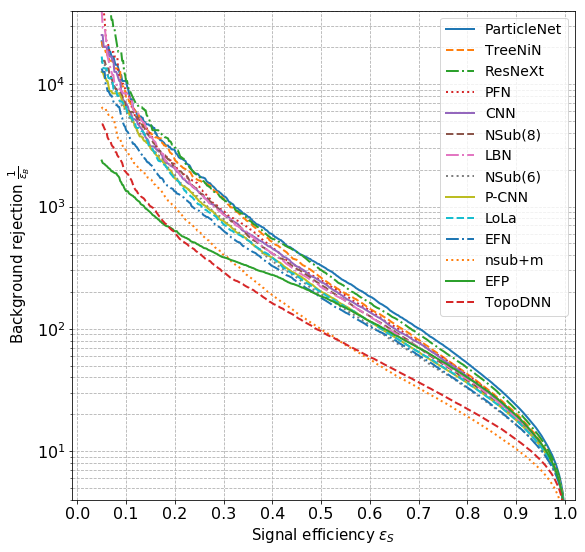

In [28]:
taggers_dict['median_bg_reject'], taggers_dict['median_aucs'], taggers_dict['median_errors'], taggers_dict['median_accuracies']  = plot_roc_all(truth,taggers_dict['median'], taggers_dict['names'], show_all=True, tag_eff=0.3, show_plot=True, plotName='ROC_allTaggers.pdf')

In [29]:
#Print results
taggers_dict['names'],taggers_dict['median_bg_reject'], taggers_dict['median_aucs'], taggers_dict['median_accuracies']  ,taggers_dict['median_errors']

(['ParticleNet',
  'TreeNiN',
  'ResNeXt',
  'PFN',
  'CNN',
  'NSub(8)',
  'LBN',
  'NSub(6)',
  'P-CNN',
  'LoLa',
  'EFN',
  'nsub+m',
  'EFP',
  'TopoDNN'],
 [1216.3493975903614,
  1153.7942857142857,
  1147.2386363636363,
  909.5225225225225,
  877.8869565217392,
  866.5836909871244,
  855.5677966101695,
  791.8196078431372,
  759.0751879699249,
  710.9647887323944,
  632.9592476489028,
  403.0219560878243,
  383.8669201520912,
  289.69010043041607],
 [0.9847607116897907,
  0.9823518474162892,
  0.9837151719575877,
  0.9818809996444435,
  0.981418680265968,
  0.9808581661093764,
  0.9810897679305932,
  0.9788940456180855,
  0.9802825331749243,
  0.9802188900156579,
  0.9788583913742932,
  0.9670978807753143,
  0.9803312707707597,
  0.9714127204825134],
 [0.9384405940594059,
  0.9331361386138614,
  0.935789603960396,
  0.9322277227722773,
  0.930789603960396,
  0.929519801980198,
  0.930920792079208,
  0.9250891089108911,
  0.9295841584158416,
  0.9292475247524753,
  0.926472772277

# ENSEMBLES - bootstrapping technique

### Get mean and median output probabilities from an ensemble of different runs

In [30]:
def mean_median_roc(input_True_labels,input_out_probs,mean=False,median=False):

    yProb=input_out_probs
    yTrue=input_True_labels

    
    if mean:
        yProb_ensemble=np.mean(yProb,axis=0)
        auc=roc_auc_score(yTrue, yProb_ensemble)
        
        acc= get_accuracy(yProb_ensemble,yTrue)
        
    elif median:
#         print('yProb[:,100]=',np.sort(yProb[:,1000]))
        yProb_ensemble=np.median(yProb,axis=0)
        auc=roc_auc_score(yTrue, yProb_ensemble) 
#         print('yProb shape=',np.shape(yProb))
#         print('median yProb[100]=',yProb[1000])
#         print('yTrue=',yTrue[1000])
        acc= get_accuracy(yProb_ensemble,yTrue)

    if mean!=median: #Only one of them should be true 
#         print(np.shape(yProb))
        fpr, tpr, thresholds = roc_curve(yTrue, yProb_ensemble,pos_label=1, drop_intermediate=False)
        return fpr, tpr, auc, acc, yProb_ensemble

### Get ensembles for all possible combinations of 6 models out of 9

In [33]:
import itertools 
def get_ensemble(input_True_labels,input_out_probs,tag_eff=0.3, median_AUC=True):

    
    all_combinations= np.asarray(list(itertools.combinations([0,1,2,3,4,5,6,7,8],6)))
    print("Total independent combinations = ", len(all_combinations))
    mean_ensemble_list=[]
    median_ensemble_list=[]
    
    base_tpr = np.linspace(0.05, 1, 476)
    
    
    #---------------------------------------
    #Get tag efficiency working point
    if tag_eff==0.5:
        point=225 #0.05 + 225*(1 - 0.05)/476=0.5
    elif tag_eff==0.3:
        point=125 #0.05 + 125*(1 - 0.05)/476=0.3
    elif tag_eff==0.4:
        point=175
    

    for k,element in enumerate(all_combinations):

            #--------------------
            # Mean ensemble
            fpr_mean, tpr_mean, auc_mean, acc_mean, yProb_ensemble_mean = mean_median_roc(input_True_labels,input_out_probs[element], mean=True)      
            
            inv_fpr_mean = interp(base_tpr, tpr_mean, 1. / fpr_mean)
#                         print('inv_fpr_mean[point]=',inv_fpr_mean[point])
            mean_ensemble_list.append((inv_fpr_mean[point],k,yProb_ensemble_mean, auc_mean)) 
#             bg_reject_tuples_mean.append(())


            #--------------------
            # Median ensemble
            fpr_median, tpr_median, auc_median, acc_median, yProb_ensemble_median = mean_median_roc(input_True_labels,input_out_probs[element],median=True)
            
            inv_fpr_median = interp(base_tpr, tpr_median, 1. / fpr_median)
            median_ensemble_list.append((inv_fpr_median[point],k,yProb_ensemble_median, auc_median)) 
            
            
    #---------------
    # Get std
    std_mean= np.std( [x for (x,y,z,q) in mean_ensemble_list])
    std_median=np.std( [x for (x,y,z,q) in median_ensemble_list])
    
    #---------------
    # Choose median ensemble ordered by AUC if median_AUC=True or bg rejection at tag efficiency=tag_eff  otherwise (both for mean and median)
    if median_AUC:
        sorted_mean=sorted(mean_ensemble_list,key=lambda x: x[3]) 
        mean_ensemble_median_model=sorted_mean[len(sorted_mean)//2]

        sorted_median=sorted(median_ensemble_list,key=lambda x: x[3])                
        median_ensemble_median_model=sorted_median[len(sorted_median)//2]        
    
    else:
        sorted_mean=sorted(mean_ensemble_list,key=lambda x: x[0])                
        mean_ensemble_median_model=sorted_mean[len(sorted_mean)//2]

        sorted_median=sorted(median_ensemble_list,key=lambda x: x[0])                
        median_ensemble_median_model=sorted_median[len(sorted_median)//2]    
    

    return mean_ensemble_median_model[2], median_ensemble_median_model[2], std_mean, std_median

In [35]:
# Calculate ensembles for all taggers and save the ensemble that gives the median bg reject
def calculate_ensembles(input_taggers_dict):
    dic={}
    dic['mean_ensemble_out_prob']=[]
    dic['median_ensemble_out_prob']=[]

    dic['mean_ensemble_std']=[]
    dic['median_ensemble_std']=[]

    for i in range(len(input_taggers_dict['out_prob'])):
        mean_ensemble, median_ensemble, std_mean, std_median = get_ensemble(truth,input_taggers_dict['out_prob'][i], median_AUC=False)

        dic['mean_ensemble_out_prob'].append(mean_ensemble)
        dic['median_ensemble_out_prob'].append(median_ensemble)
        dic['mean_ensemble_std'].append(std_mean)
        dic['median_ensemble_std'].append(std_median)
        
    return  dic['mean_ensemble_out_prob'], dic['median_ensemble_out_prob'], dic['mean_ensemble_std'], dic['median_ensemble_std']

In [36]:
# Set to true if new taggers are added (run only once and save taggers_dict below)
run_ensembles=False

if run_ensembles:
    taggers_dict['mean_ensemble_out_prob'], taggers_dict['median_ensemble_out_prob'], taggers_dict['mean_ensemble_std'], taggers_dict['median_ensemble_std'] = calculate_ensembles(taggers_dict)

Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84
Total independent combinations =  84


In [37]:
if save_results:
    with open('taggers_dict.pkl', "wb") as f: pickle.dump(taggers_dict, f)

In [38]:
#Load taggers_dict
with open('taggers_dict.pkl', "rb") as f: taggers_dict=pickle.load(f)

In [33]:
# Show mean ensembles stds
taggers_dict['names'], taggers_dict['mean_ensemble_std']

(['ParticleNet',
  'TreeNiN',
  'ResNeXt',
  'PFN',
  'CNN',
  'NSub(8)',
  'LBN',
  'NSub(6)',
  'P-CNN',
  'LoLa',
  'EFN',
  'nsub+m',
  'EFP',
  'TopoDNN'],
 [45.167531257786386,
  22.78888462186303,
  28.154324241895257,
  21.19735388669292,
  15.207264135502275,
  19.50578373414383,
  67.09664734622058,
  12.115320855663128,
  12.611225671521723,
  10.633870020901671,
  12.789630231223716,
  1.1368683772161603e-13,
  1.1368683772161603e-13,
  5.032537963958833])

In [40]:
# Show median ensembles stds
taggers_dict['names'],taggers_dict['median_ensemble_std']

(['ParticleNet',
  'TreeNiN',
  'ResNeXt',
  'PFN',
  'CNN',
  'NSub(8)',
  'LBN',
  'NSub(6)',
  'P-CNN',
  'LoLa',
  'EFN',
  'nsub+m',
  'EFP',
  'TopoDNN'],
 [41.45344363895517,
  23.73805724079428,
  30.66136047296712,
  28.696544733786354,
  17.560422372225933,
  18.45923910993531,
  20.407837190760088,
  13.153637123480536,
  13.805525888951758,
  11.215168575048468,
  11.351615405305342,
  1.1368683772161603e-13,
  1.1368683772161603e-13,
  7.539331116948343])

### Plot ROC curve for mean ensembles and get mean ensembles AUC, accuracy, bg reject and errors

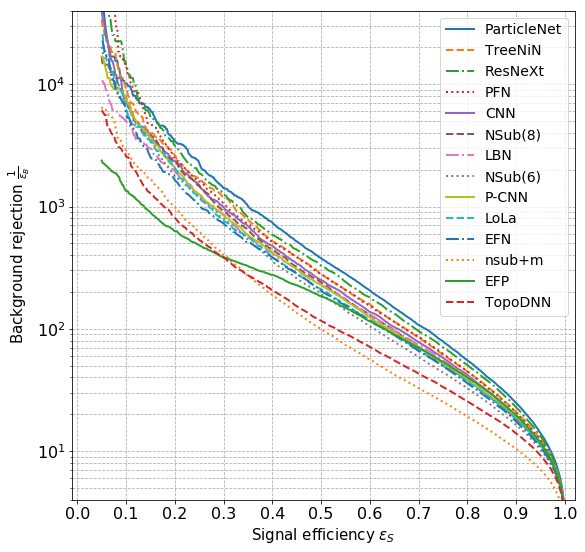

In [50]:
taggers_dict['mean_ensemble_bg_reject'], taggers_dict['mean_ensemble_aucs'], taggers_dict['mean_ensemble_stat_errors'],  taggers_dict['mean_ensemble_accuracies']   = plot_roc_all(truth,taggers_dict['mean_ensemble_out_prob'],taggers_dict['names'], show_all=True, tag_eff=0.3, show_plot=True)

In [52]:
taggers_dict['names'], taggers_dict['mean_ensemble_bg_reject'], taggers_dict['mean_ensemble_std'], taggers_dict['mean_ensemble_aucs'],taggers_dict['mean_ensemble_accuracies'] 

(['ParticleNet',
  'TreeNiN',
  'ResNeXt',
  'PFN',
  'CNN',
  'NSub(8)',
  'LBN',
  'NSub(6)',
  'P-CNN',
  'LoLa',
  'EFN',
  'nsub+m',
  'EFP',
  'TopoDNN'],
 [1411.986013986014,
  1201.8690476190477,
  1269.8993710691825,
  1062.7052631578947,
  994.6502463054187,
  917.7909090909092,
  859.2085106382979,
  798.0790513833991,
  844.8284518828452,
  767.7338403041824,
  728.9314079422383,
  403.0219560878243,
  383.8669201520912,
  382.41287878787875],
 [45.167531257786386,
  22.78888462186303,
  28.154324241895257,
  21.19735388669292,
  15.207264135502275,
  19.50578373414383,
  67.09664734622058,
  12.115320855663128,
  12.611225671521723,
  10.633870020901671,
  12.789630231223716,
  1.1368683772161603e-13,
  1.1368683772161603e-13,
  5.032537963958833],
 [0.9854183159776948,
  0.9830074275027677,
  0.9843591441481283,
  0.9828152558548581,
  0.9817773569680749,
  0.9810484748390971,
  0.9816600161591382,
  0.9788223637601755,
  0.9812566656792054,
  0.9806527018774479,
  0.9800

In [61]:
# Get percentual gain in performance from ensemble
(np.asarray(taggers_dict['mean_ensemble_bg_reject'])-np.asarray(median_bg_reject_withoutliers))/np.asarray(median_bg_reject_withoutliers) *100

array([ 9.09090909, 17.26190476, 15.72327044, 19.47368421,  8.86699507,
        5.45454545,  2.12765957,  0.79051383, 15.48117155,  5.70342205,
       15.16245487,  0.        ,  0.        , 28.78787879])

### Plot ROC curve for median ensembles and get mean ensembles AUC, accuracy, bg reject and errors

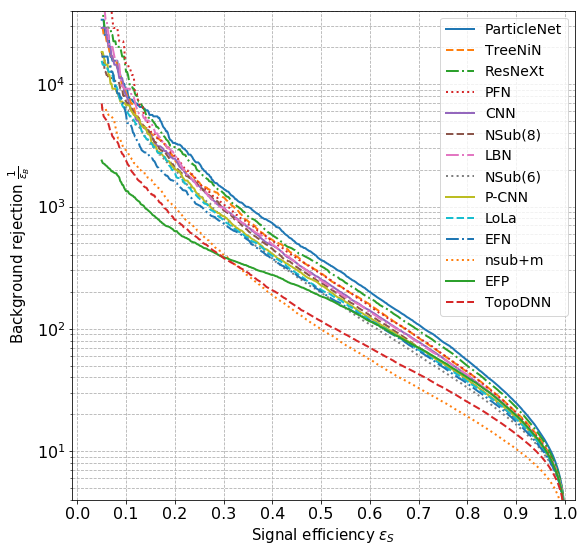

In [53]:
taggers_dict['median_ensemble_bg_reject'], taggers_dict['median_ensemble_aucs'], taggers_dict['median_ensemble_stat_errors'], taggers_dict['median_ensemble_accuracies'] = plot_roc_all(truth,taggers_dict['median_ensemble_out_prob'],taggers_dict['names'], show_all=True, tag_eff=0.3, show_plot=True)

In [54]:
taggers_dict['names'], taggers_dict['median_ensemble_bg_reject'], taggers_dict['median_ensemble_std'],  taggers_dict['median_ensemble_aucs'],taggers_dict['median_ensemble_accuracies'] 

(['ParticleNet',
  'TreeNiN',
  'ResNeXt',
  'PFN',
  'CNN',
  'NSub(8)',
  'LBN',
  'NSub(6)',
  'P-CNN',
  'LoLa',
  'EFN',
  'nsub+m',
  'EFP',
  'TopoDNN'],
 [1392.510344827586,
  1187.729411764706,
  1286.0764331210191,
  1051.6354166666667,
  975.4299516908212,
  926.211009174312,
  966.0956937799044,
  807.6560000000001,
  834.3553719008264,
  764.8257575757575,
  726.3093525179856,
  403.0219560878243,
  383.8669201520912,
  378.11610486891385],
 [41.45344363895517,
  23.73805724079428,
  30.66136047296712,
  28.696544733786354,
  17.560422372225933,
  18.45923910993531,
  20.407837190760088,
  13.153637123480536,
  13.805525888951758,
  11.215168575048468,
  11.351615405305342,
  1.1368683772161603e-13,
  1.1368683772161603e-13,
  7.539331116948343],
 [0.9853529674583509,
  0.9829489863957136,
  0.9843024674394923,
  0.9827511494566098,
  0.9817770602201534,
  0.9810473496550878,
  0.9820562384028022,
  0.979080111062065,
  0.9811730775967082,
  0.9806996867281365,
  0.9799221

In [60]:
# Get percentual gain in performance from ensemble
(np.asarray(taggers_dict['median_ensemble_bg_reject'])-np.asarray(median_bg_reject_withoutliers))/np.asarray(median_bg_reject_withoutliers) *100

array([ 7.5862069 , 15.88235294, 17.19745223, 18.22916667,  6.76328502,
        6.42201835, 14.83253589,  2.        , 14.04958678,  5.3030303 ,
       14.74820144,  0.        ,  0.        , 27.34082397])

#### Save dictionary with results

In [55]:
if save_results:
    with open('taggers_dict.pkl', "wb") as f: pickle.dump(taggers_dict, f)

In [48]:
#Load taggers_dict
with open('taggers_dict.pkl', "rb") as f: taggers_dict=pickle.load(f)

# REWEIGHT HISTOGRAMS

In [41]:
# GET WEIGHTS TO FLATTEN DISTRIBUTIONS
def flatten_hist(input_True_labels, input_variable, input_weights2=None, num_bins=20,bin_start=None, bin_finish=None):
    
    
    # Weights for flatness in pt
    weights = np.zeros((len(input_variable)),dtype=np.longdouble)
    
    
    #------------------------------------
    #REWEIGHT SIGNAL
    variable_sg=[input_variable[i] for i in range(len(input_True_labels)) if input_True_labels[i] == 1]
    
    input_weights2_sg=None
    if np.all(input_weights2) != None:
        input_weights2_sg=[input_weights2[i] for i in range(len(input_True_labels)) if input_True_labels[i] == 1]

    # pdf is the entries in each bin of the histogram and edges are the histogram bin edges. If density=True, the result is the value of the probability density function at the bin, normalized such that the integral over the range is 1.
    pdf, edges = np.histogram(variable_sg, density=True, range=[bin_start, bin_finish], bins=num_bins, weights=input_weights2_sg)
    
    #Check hist normalization
#     print('hist normalization=', np.sum(pdf*(bin_finish-bin_start)/num_bins))

    # Find the position where each of the  variable (eta, E, pT, etc) values fits in the sorted list of bin edges
    indices = np.searchsorted(edges, variable_sg, side='left', ) -1
#     print('indices=',np.sort(indices)[-1])
    
    # Make a list with the density contribution of each jet
    variable_density= pdf[indices] 

    # The contribution after reweighting should be inversely proportional to the density
    inv_weights = 1. / variable_density

    #Normalize to 1. This way in each bin we have the same number of entries, and the total area is 1.
    inv_weights = inv_weights/inv_weights.sum()

    #Fill weights hist
    weights[input_True_labels==1]  =   inv_weights              


    #------------------------------------
    #REWEIGHT BACKGROUND
    variable_bg=[input_variable[i] for i in range(len(input_True_labels)) if input_True_labels[i] == 0]
    
    input_weights2_bg=None
    if np.all(input_weights2) != None:
        input_weights2_bg=[input_weights2[i] for i in range(len(input_True_labels)) if input_True_labels[i] == 0]

    # pdf is the entries in each bin of the histogram and edges are the histogram bin edges. If density=True, the result is the value of the probability density function at the bin, normalized such that the integral over the range is 1.
    pdf, edges = np.histogram(variable_bg, density=True, range=[bin_start, bin_finish], bins=num_bins, weights=input_weights2_bg)
    
    #Check hist normalization
#     print('hist normalization=', np.sum(pdf*(bin_finish-bin_start)/num_bins))

    # Find the position where each of the  variable (eta, E, pT, etc) values fits in the sorted list of bin edges
    indices = np.searchsorted(edges, variable_bg, side='left', ) - 1
    

    # Make a list with the density contribution of each jet
    variable_density= pdf[indices] 

    # The contribution after reweighting should be inversely proportional to the density
    inv_weights = 1. / variable_density

    #Normalize to 1. This way in each bin we have the same number of entries, and the total area is 1.
    inv_weights = inv_weights/inv_weights.sum()

    #Fill weights hist
    weights[input_True_labels==0]  =   inv_weights 

        
    return weights

In [42]:
# Plot histograms reweighting the inputs
def plot_weighted_hist(input_variable,input_True_labels,input_weights, input_weights2=None, title='',xlabel='',ylabel='',Range=None, bins=None, loc='best',variable_str='',info=''):
    
    
    input_weights= np.asarray(input_weights)
    
    TreeNiN_sg=input_variable[input_True_labels==1]
    TreeNiN_bg=input_variable[input_True_labels==0]
    

    input_weights2_bg=None
    input_weights2_sg=None
    if np.all(input_weights2) != None:
        input_weights2_sg=[input_weights2[input_True_labels==1]]
        input_weights2_bg=[input_weights2[input_True_labels==0]]
    
    
    
    
    plt.hist(TreeNiN_sg, density=True, weights=input_weights2_sg, bins=bins, histtype="step", fill=False, align='mid',range=Range,label='top -- '+str(variable_str))
    plt.hist(TreeNiN_bg ,density=True, weights=input_weights2_bg, bins=bins, histtype="step", fill=False, align='mid',range=Range,label='qcd -- '+str(variable_str))    

    
    plt.hist(TreeNiN_sg, density=True, weights=input_weights[input_True_labels==1], bins=bins, histtype="step", fill=False, align='mid',range=Range,label='top -- '+str(variable_str)+' weighted'+str(info))
    plt.hist(TreeNiN_bg ,density=True, weights=input_weights[input_True_labels==0], bins=bins, histtype="step", fill=False, align='mid',range=Range,label='qcd -- '+str(variable_str)+' weighted'+str(info))



    plt.title(str(title))
#     plt.xlabel(str(xlabel), fontsize=15)
#     plt.ylabel(str(ylabel), fontsize=15)
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
#     plt.xlim([-0.01, 1.02])
#     plt.ylim(1, 200000)
#     plt.yscale("log")
    plt.legend(loc=loc)
    plt.grid(which='both',axis='both',linestyle='--')
    plt.show()
    

In [43]:
# Get new AUC after reweighting histograms
def get_auc_roc(input_TreeNiN, input_True_labels, input_weights=None,tag_eff=0.3):
    
    #Get tag efficiency working point
    if tag_eff==0.5:
        point=225 #0.05 + 225*(1 - 0.05)/476=0.5
    elif tag_eff==0.3:
        point=125 #0.05 + 125*(1 - 0.05)/476=0.3
    elif tag_eff==0.4:
        point=175  
        
#     weights=np.concatenate((np.ones((len(TreeNiN)-100000)) ,np.zeros((100000))))
    auc=roc_auc_score(input_True_labels, input_TreeNiN, sample_weight=input_weights)

    
    fpr, tpr, thresholds = roc_curve(input_True_labels, input_TreeNiN ,pos_label=1, sample_weight=input_weights, drop_intermediate=False)

    
    base_tpr = np.linspace(0.05, 1, 476)
    inv_fpr = interp(base_tpr, tpr, 1. / fpr)

    len_bg = len(input_True_labels[input_True_labels==0])
    
    bg_eff=1./inv_fpr[point]
#     error_abs=np.sqrt((1./inv_fpr[point])*len_bg)/len_bg        
#     error_rel=error_abs/(1./inv_fpr[point])

    error_rel=np.sqrt(1./(bg_eff*len_bg))
    
    error=error_rel*inv_fpr[point]

#     print('ROC AUC = ',auc)
#     print('Bg rejection at ',str(tag_eff),' tag eff = ',inv_fpr[point],'+-',error)
    
    return auc, inv_fpr[point], error

#### Load TreeNiN dictionaries to access jet level information (do only once)

In [44]:
def load_variable(toptag_reference_test,variable_type=None):
    
#     toptag_reference_test='../data/inputTrees/top_tag_reference_dataset/tree_test_jets.pkl'
    with open(toptag_reference_test, "rb") as f: toptag_reference_test =pickle.load(f,encoding='latin-1')
        
    toptag_reference_test_x=np.asarray([x for (x,y) in toptag_reference_test])
    toptag_reference_test_y=np.asarray([y for (x,y) in toptag_reference_test])

    variable=[toptag_reference_test_x[i][str(variable_type)] for i in range(0,len(toptag_reference_test_x))]
    
    return variable

In [45]:
def load_pz(toptag_reference_test,variable_type=None):
    
#     toptag_reference_test='../data/inputTrees/top_tag_reference_dataset/tree_test_jets.pkl'
    with open(toptag_reference_test, "rb") as f: toptag_reference_test =pickle.load(f,encoding='latin-1')
        
    toptag_reference_test_x=np.asarray([x for (x,y) in toptag_reference_test])
    toptag_reference_test_y=np.asarray([y for (x,y) in toptag_reference_test])
    
    
    
    variable=[toptag_reference_test_x[i]["content"][toptag_reference_test_x[i]["root_id"], 2] for i in range(0,len(toptag_reference_test_x))]
    
    return variable

In [46]:
# Switch to True if data changes (do only once)
save_jet_info=False

if save_jet_info:
    Eta_variable = load_variable('../../data/inputTrees/top_tag_reference_dataset/tree_test_jets_404k.pkl',variable_type='eta')
    E_variable = load_variable('../../data/inputTrees/top_tag_reference_dataset/tree_test_jets_404k.pkl',variable_type='energy')
    pT_variable = load_variable('../../data/inputTrees/top_tag_reference_dataset/tree_test_jets_404k.pkl',variable_type='pt')
    pz_variable = load_pz('../../data/inputTrees/top_tag_reference_dataset/tree_test_jets_404k.pkl',variable_type=None)

In [47]:
# Save jet kinematic variables
if save_jet_info:
    with open('jets_kinematics/eta.pkl', "wb") as f: pickle.dump(Eta_variable, f)
    with open('jets_kinematics/energy.pkl', "wb") as f: pickle.dump(E_variable, f)
    with open('jets_kinematics/pt.pkl', "wb") as f: pickle.dump(pT_variable, f)
    with open('jets_kinematics/pz.pkl', "wb") as f: pickle.dump(pz_variable, f)

#### Load jet level variables

In [48]:
#Load kinematic variables
with open('jets_kinematics/eta.pkl','rb') as f: Eta_variable=pickle.load(f)
with open('jets_kinematics/energy.pkl','rb') as f: E_variable=pickle.load(f)    
with open('jets_kinematics/pt.pkl','rb') as f: pT_variable=pickle.load(f)
with open('jets_kinematics/pz.pkl','rb') as f: pz_variable=pickle.load(f)

### Crop variables

In [49]:
Eta_variable=np.asarray(Eta_variable)
E_variable=np.asarray(E_variable)
pT_variable=np.asarray(pT_variable)
pz_variable=np.asarray(pz_variable)
True_labels=truth

print('Shape Eta_variable = ', np.shape(Eta_variable))
print('Shape E_variable = ', np.shape(E_variable))
print('Shape pT_variable = ', np.shape(pT_variable))
print('Shape pz_variable = ', np.shape(pz_variable))
print('Shape True_labels = ', np.shape(True_labels))

#-----------------------------------
# CROP
E_start=500
E_finish=2400
eta_start=-2
eta_finish=2
pT_start=550
pT_finish=650
pz_start=-2300
pz_finish=2280


Eta_crop=np.asarray([Eta_variable[i] for i in range(len(Eta_variable)) if  E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish and pz_start<pz_variable[i]<pz_finish])

E_crop=np.asarray([E_variable[i] for i in range(len(E_variable)) if  E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish and pz_start<pz_variable[i]<pz_finish])

pT_crop=np.asarray([pT_variable[i] for i in range(len(pT_variable)) if  E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish and pz_start<pz_variable[i]<pz_finish])

pz_crop=np.asarray([pz_variable[i] for i in range(len(pz_variable)) if  E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish and pz_start<pz_variable[i]<pz_finish])



True_labels_crop=np.asarray([True_labels[i] for i in range(len(True_labels)) if  E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish and pz_start<pz_variable[i]<pz_finish])

# TreeNiN_crop=np.asarray([TreeNiN_prob[i] for i in range(len(TreeNiN_prob)) if E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish])


print('Shape Eta_crop = ', np.shape(Eta_crop))
print('Shape E_crop = ', np.shape(E_crop))
print('Shape pT_crop = ', np.shape(pT_crop))
print('Shape pz_crop = ', np.shape(pz_crop))
print('Shape True_labels_crop = ', np.shape(True_labels_crop))
# print('Shape TreeNiN_crop = ', np.shape(TreeNiN_crop))

Shape Eta_variable =  (404000,)
Shape E_variable =  (404000,)
Shape pT_variable =  (404000,)
Shape pz_variable =  (404000,)
Shape True_labels =  (404000,)
Shape Eta_crop =  (403242,)
Shape E_crop =  (403242,)
Shape pT_crop =  (403242,)
Shape pz_crop =  (403242,)
Shape True_labels_crop =  (403242,)


### Crop out_prob for model with median auc for all taggers

In [50]:
# Crop out_prob for model with median auc 
def crop_out_prob(input_taggers_dict):
    temp_dict={}
    temp_dict['crop_median']=[]
    
    for k in range(np.shape(input_taggers_dict['median'])[0]):
        crop_prob = np.asarray([input_taggers_dict['median'][k][i] for i in range(len(input_taggers_dict['median'][k])) if E_start< E_variable[i] < E_finish and eta_start<Eta_variable[i]<eta_finish and pT_start<pT_variable[i]<pT_finish  and pz_start<pz_variable[i]<pz_finish])
    
        temp_dict['crop_median'].append(crop_prob)
        
    print('Shape crop_median = ', np.shape(temp_dict['crop_median']))
    
    return temp_dict['crop_median']

In [51]:
taggers_dict['crop_median'] = crop_out_prob(taggers_dict)

Shape crop_median =  (14, 403242)


In [52]:
if save_results:
    with open('taggers_dict.pkl', "wb") as f: pickle.dump(taggers_dict, f)

In [53]:
#Load taggers_dict
with open('taggers_dict.pkl', "rb") as f: taggers_dict=pickle.load(f)

## Flatten histograms 

In [54]:
#Select the model (median AUC based)
TreeNiN_crop= np.asarray(taggers_dict['crop_median'][1])

### Flatten eta

Weights shape =  (403242,)


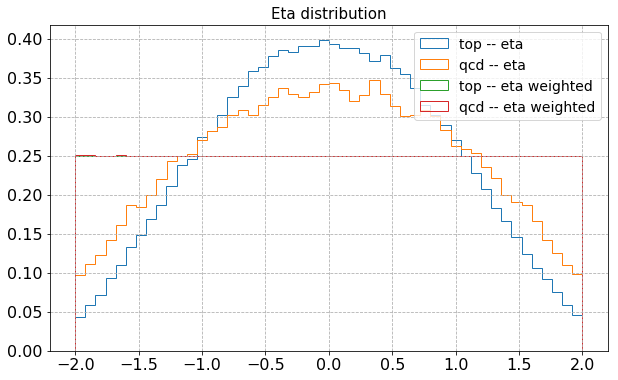

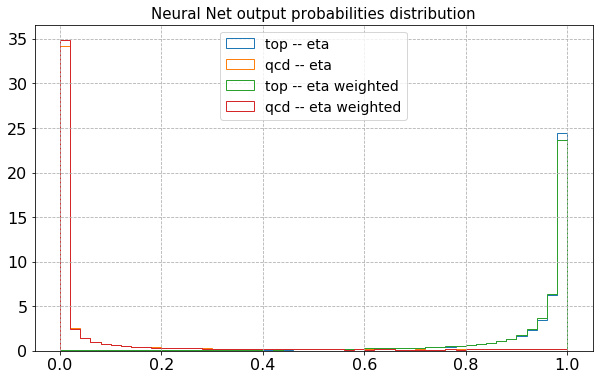

In [55]:
plt.rcParams['figure.figsize'] = 10,6


nbins=50
variable_str='eta'
tag_eff=0.3
bin_start=-2
bin_finish=2

variable_crop=Eta_crop

eta_weights = flatten_hist(True_labels_crop, variable_crop,num_bins=nbins,bin_start=bin_start, bin_finish=bin_finish)
print('Weights shape = ',np.shape(eta_weights))

# Eta histogram
plot_weighted_hist(variable_crop,True_labels_crop,eta_weights, title='Eta distribution',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)

# NN output prob histogram
plot_weighted_hist(TreeNiN_crop,True_labels_crop,eta_weights, title='Neural Net output probabilities distribution', xlabel='', ylabel='', Range=None, bins=nbins, loc='upper center', variable_str=variable_str)



### Flatten pT

Weights shape =  (403242,)


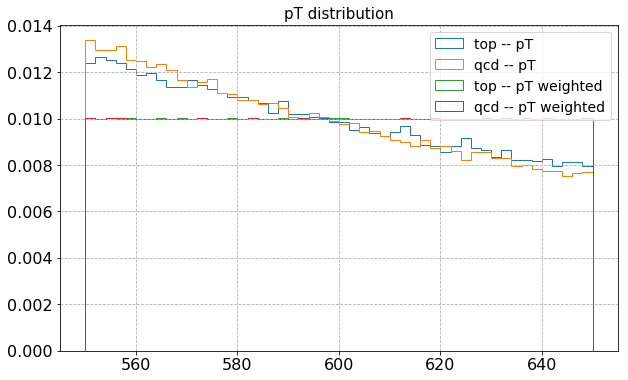

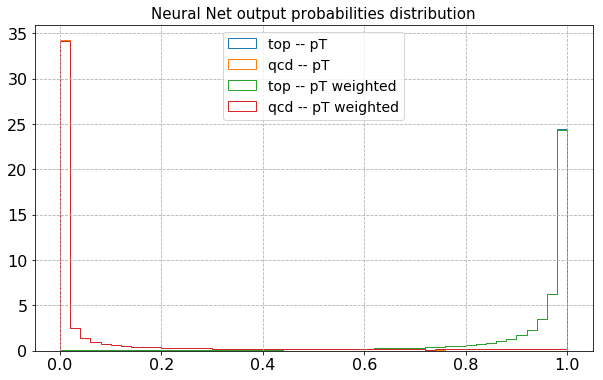

In [56]:
nbins=50
variable_str='pT'
tag_eff=0.3
bin_start=550
bin_finish=650

variable_crop=pT_crop

pT_weights = flatten_hist(True_labels_crop, variable_crop,num_bins=nbins,bin_start=bin_start, bin_finish=bin_finish)
print('Weights shape = ',np.shape(eta_weights))

# pT histogram
plot_weighted_hist(variable_crop,True_labels_crop,pT_weights, title='pT distribution',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)

# NN output prob histogram
plot_weighted_hist(TreeNiN_crop,True_labels_crop,pT_weights, title='Neural Net output probabilities distribution', xlabel='', ylabel='', Range=None, bins=nbins, loc='upper center', variable_str=variable_str)



### Flatten energy

Weights shape =  (403242,)


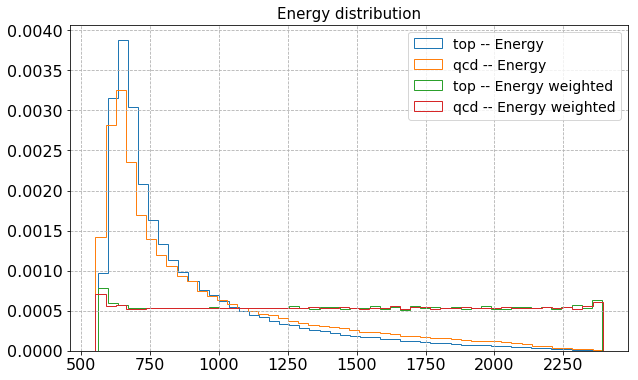

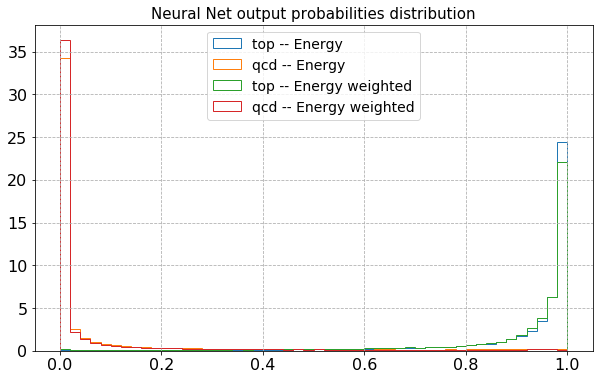

In [57]:
# FLATTEN ENERGY DISTRIBUTION AND GET CHANGE IN NN OUTPUT PROBABILITIES
nbins=50
variable_str='Energy'
tag_eff=0.3
bin_start=500
bin_finish=2400

variable_crop=E_crop

E_weights = flatten_hist(True_labels_crop, variable_crop,num_bins=nbins,bin_start=bin_start, bin_finish=bin_finish)
print('Weights shape = ',np.shape(E_weights))

# Eta histogram
plot_weighted_hist(variable_crop,True_labels_crop,E_weights, title='Energy distribution',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)

# NN output prob histogram
plot_weighted_hist(TreeNiN_crop,True_labels_crop,E_weights, title='Neural Net output probabilities distribution', xlabel='', ylabel='', Range=None, bins=nbins, loc='upper center', variable_str=variable_str)



### Flatten pz

Weights shape =  (403242,)


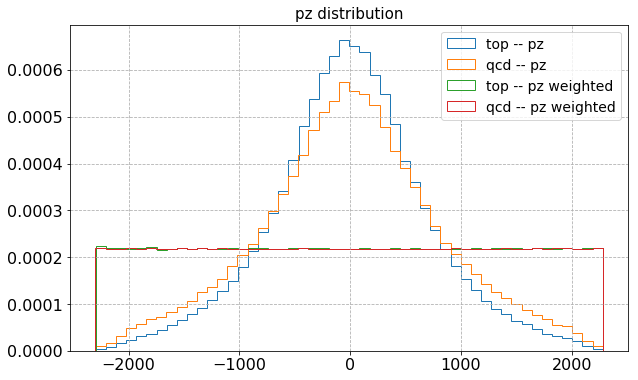

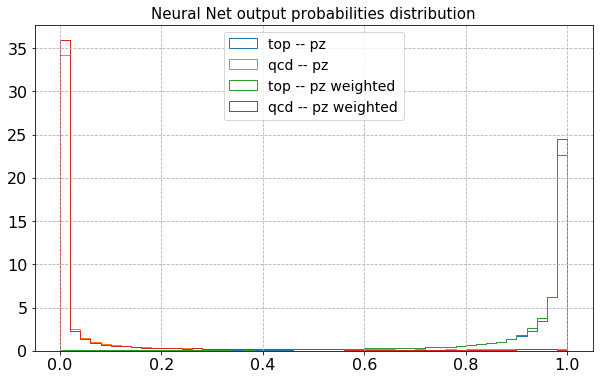

In [58]:
nbins=50
variable_str='pz'
tag_eff=0.3
bin_start= -2300
bin_finish=2280

variable_crop=pz_crop

pz_weights = flatten_hist(True_labels_crop, variable_crop,num_bins=nbins,bin_start=bin_start, bin_finish=bin_finish)
print('Weights shape = ',np.shape(pz_weights))

# Eta histogram
plot_weighted_hist(variable_crop,True_labels_crop,pz_weights, title='pz distribution',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)

# NN output prob histogram
plot_weighted_hist(TreeNiN_crop,True_labels_crop,pz_weights, title='Neural Net output probabilities distribution', xlabel='', ylabel='', Range=None, bins=nbins, loc='upper center', variable_str=variable_str)



### Reweight the energy distribution with the weights that flatten the pT distribution and get change in NN output probabilities

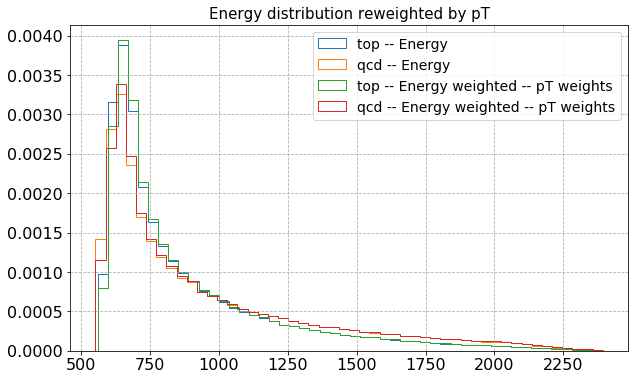

Weights shape =  (403242,)


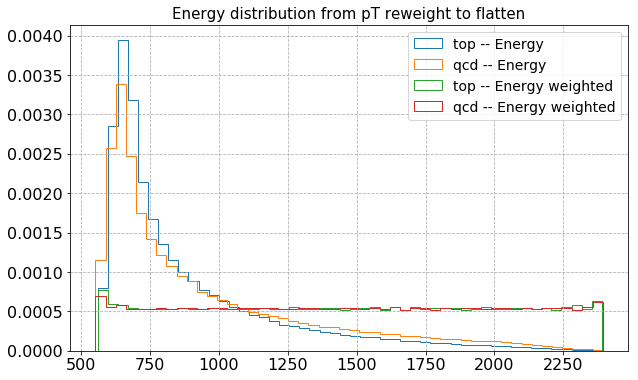

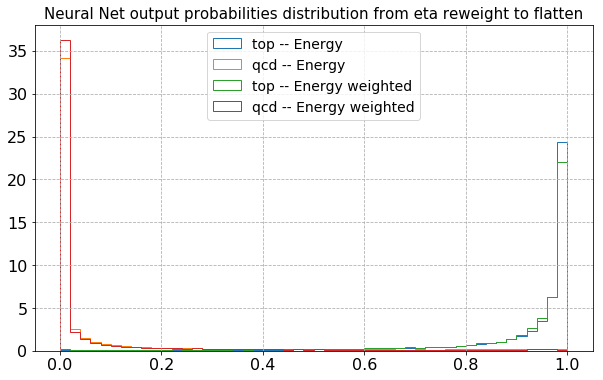

In [59]:
# REWEIGHT ENERGY DISTRIBUTION WITH THE WEIGHTS THAT FLATTEN THE pT DISTRIBUTION AND GET CHANGE IN NN OUTPUT PROBABILITIES
nbins=50
variable_str='Energy'
tag_eff=0.3
bin_start=500
bin_finish=2400

variable_crop=E_crop



# E histogram using the weights that flatten eta
plot_weighted_hist(variable_crop,True_labels_crop,pT_weights, title='Energy distribution reweighted by pT',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str, info=' -- pT weights')

# Flatten the E distribution after reweighting with eta
E_pT_weights = flatten_hist(True_labels_crop, variable_crop,num_bins=nbins,bin_start=bin_start, bin_finish=bin_finish, input_weights2=pT_weights)
print('Weights shape = ',np.shape(E_pT_weights))

# Check that the E distribution in flattened
global_weights=pT_weights*E_pT_weights
global_weights=(global_weights/np.sum(global_weights))*np.sum(pT_weights)

plot_weighted_hist(variable_crop,True_labels_crop,global_weights, input_weights2=pT_weights, title='Energy distribution from pT reweight to flatten',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)


# plot_weighted_hist(variable_crop,True_labels_crop,E_weights, input_weights2=pT_weights, title='Energy distribution reweighted by Energy',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)

# NN output prob histogram
plot_weighted_hist(TreeNiN_crop,True_labels_crop,global_weights, input_weights2=pT_weights, title='Neural Net output probabilities distribution from eta reweight to flatten', xlabel='', ylabel='', Range=None, bins=nbins, loc='upper center', variable_str=variable_str)


### Reweight the energy distribution with the weights that flatten the eta distribution and get change in NN output probabilities

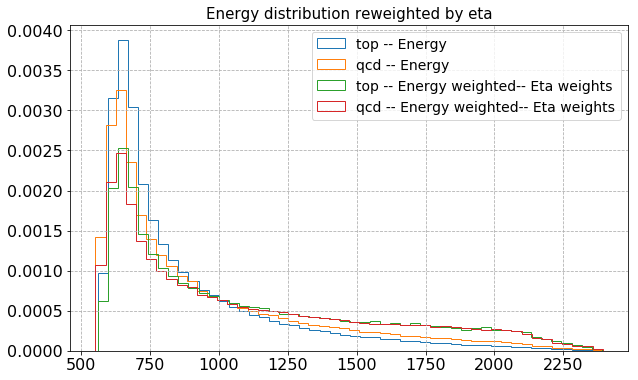

Weights shape =  (403242,)


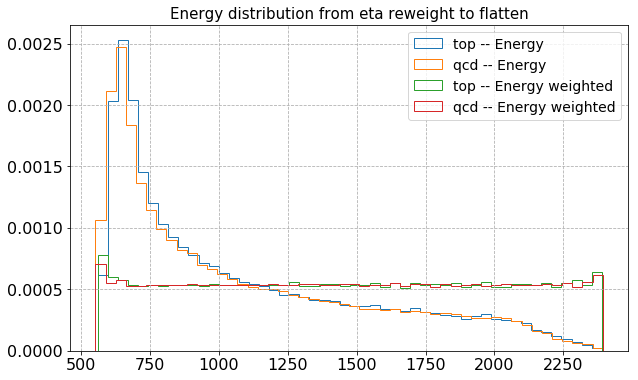

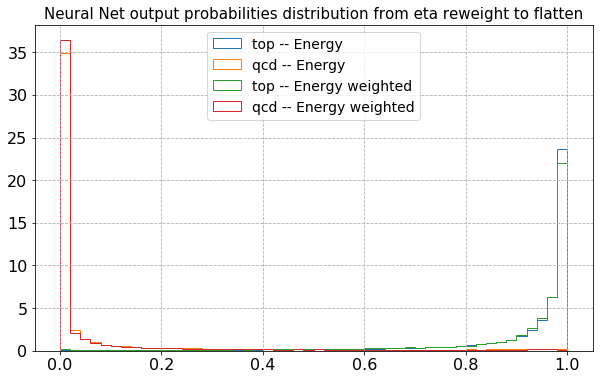

In [60]:
# REWEIGHT ENERGY DISTRIBUTION WITH THE WEIGHTS THAT FLATTEN THE ETA DISTRIBUTION AND GET CHANGE IN NN OUTPUT PROBABILITIES
nbins=50
variable_str='Energy'
tag_eff=0.3
bin_start=500
bin_finish=2400

variable_crop=E_crop



# E histogram using the weights that flatten eta
plot_weighted_hist(variable_crop,True_labels_crop,eta_weights, title='Energy distribution reweighted by eta',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str, info='-- Eta weights')

# Flatten the E distribution after reweighting with eta
E_eta_weights = flatten_hist(True_labels_crop, variable_crop,num_bins=nbins,bin_start=bin_start, bin_finish=bin_finish, input_weights2=eta_weights)
print('Weights shape = ',np.shape(E_eta_weights))

# Check that the E distribution in flattened
global_weights=eta_weights*E_eta_weights
global_weights=(global_weights/np.sum(global_weights))*np.sum(eta_weights)

plot_weighted_hist(variable_crop,True_labels_crop,global_weights, input_weights2=eta_weights, title='Energy distribution from eta reweight to flatten',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)


# plot_weighted_hist(variable_crop,True_labels_crop,E_weights, input_weights2=eta_weights, title='Energy distribution from eta reweight to flatten',xlabel='',ylabel='',Range=None, bins=nbins, variable_str=variable_str)

# NN output prob histogram
plot_weighted_hist(TreeNiN_crop,True_labels_crop,global_weights, input_weights2=eta_weights, title='Neural Net output probabilities distribution from eta reweight to flatten', xlabel='', ylabel='', Range=None, bins=nbins, loc='upper center', variable_str=variable_str)


In [61]:
np.int(np.sum(E_weights/global_weights))

406616

In [62]:
np.shape(E_weights)

(403242,)

## Reweight output probabilities off all the taggers

In [63]:
def reweight_out_prob(input_taggers_dict, input_True_labels_crop, input_weights, tag_eff=0.3):

    temp_auc=[]
    temp_bg_reject=[]
    temp_error=[]
    for k in range(len(input_taggers_dict['crop_median'])):
        
        # Reweighted distributions
        reweight_auc,reweight_bg_reject, reweight_error  = get_auc_roc(input_taggers_dict['crop_median'][k], input_True_labels_crop, input_weights=input_weights, tag_eff=tag_eff)
        
        temp_auc.append(reweight_auc)
        temp_bg_reject.append(reweight_bg_reject)
        temp_error.append(reweight_error)

    return temp_auc, temp_bg_reject, temp_error

In [64]:
taggers_dict['crop_auc'], taggers_dict['crop_bg_reject'], taggers_dict['crop_error'] = reweight_out_prob(taggers_dict, True_labels_crop, None, tag_eff=0.3)

In [65]:
taggers_dict['eta_flatten_auc'], taggers_dict['eta_flatten_bg_reject'], taggers_dict['eta_flatten_error'] = reweight_out_prob(taggers_dict, True_labels_crop, eta_weights, tag_eff=0.3)

In [66]:
taggers_dict['energy_flatten_auc'], taggers_dict['energy_flatten_bg_reject'], taggers_dict['energy_flatten_error'] = reweight_out_prob(taggers_dict, True_labels_crop, E_weights, tag_eff=0.3)

In [67]:
taggers_dict['pT_flatten_auc'], taggers_dict['pT_flatten_bg_reject'], taggers_dict['pT_flatten_error'] = reweight_out_prob(taggers_dict, True_labels_crop, pT_weights, tag_eff=0.3)

In [68]:
taggers_dict['pz_flatten_auc'], taggers_dict['pz_flatten_bg_reject'], taggers_dict['pz_flatten_error'] = reweight_out_prob(taggers_dict, True_labels_crop, pz_weights, tag_eff=0.3)

In [69]:
taggers_dict['names']

['ParticleNet',
 'TreeNiN',
 'ResNeXt',
 'PFN',
 'CNN',
 'NSub(8)',
 'LBN',
 'NSub(6)',
 'P-CNN',
 'LoLa',
 'EFN',
 'nsub+m',
 'EFP',
 'TopoDNN']

In [70]:
taggers_dict['crop_bg_reject'], taggers_dict['pT_flatten_bg_reject'], taggers_dict['eta_flatten_bg_reject'],taggers_dict['energy_flatten_bg_reject'], taggers_dict['pz_flatten_bg_reject']

([1213.6265060240964,
  1157.8275862068965,
  1144.6704545454545,
  907.4864864864865,
  879.7467248908297,
  868.3706896551724,
  853.6525423728814,
  790.0470588235294,
  763.1136363636363,
  714.4042553191489,
  635.5268138801262,
  402.92400000000004,
  390.43023255813955,
  290.7099567099567],
 [1211.2430510838244,
  1124.1310819985067,
  1133.1776706290104,
  901.3558748607256,
  843.2723449625489,
  858.2751635433499,
  821.9045894435933,
  770.1280096453512,
  749.6306499676734,
  695.2709574685041,
  612.801340591372,
  397.71294181484467,
  381.6166799362641,
  285.0224015249906],
 [1143.2144735048473,
  1069.205851734409,
  1141.5634098240162,
  914.2080025627591,
  885.6124544054604,
  889.4544559261639,
  845.463094212356,
  806.337668756462,
  752.7380895986386,
  679.020804562258,
  646.3781198437732,
  423.403889099522,
  393.00564655840964,
  310.79514727483735],
 [1244.250163860867,
  1034.5741456138542,
  1189.2092788667903,
  870.191845287458,
  896.3746411617711,
 

### Plot the background rejection of each tagger for all the flattened variables

In [71]:
# def invert_order(input_names,input_taggers_dict):

#     flatten_dict={}
#     for i,name in enumerate(input_names):
#         flatten_dict[str(name)]=[]
#         flatten_dict[str(name)].append(input_taggers_dict['crop_bg_reject'][i])
#         flatten_dict[str(name)].append(input_taggers_dict['pT_flatten_bg_reject'][i])
#         flatten_dict[str(name)].append(input_taggers_dict['eta_flatten_bg_reject'][i])
#         flatten_dict[str(name)].append(input_taggers_dict['pz_flatten_bg_reject'][i])
#         flatten_dict[str(name)].append(input_taggers_dict['energy_flatten_bg_reject'][i])
        
#     return flatten_dict

# flatten_dict = invert_order(taggers_dict['names'], taggers_dict)

#### Concatenate errors and reshape to add error bars to the plot

In [74]:
bar_plot_error_transpose=np.asarray([taggers_dict['crop_error'], taggers_dict['pT_flatten_error'], taggers_dict['eta_flatten_error'], taggers_dict['pz_flatten_error'] , taggers_dict['energy_flatten_error'] ])
bar_plot_error_transpose

array([[94.19568507, 87.77468279, 86.28278196, 60.90650504, 58.13529995,
        57.01132883, 55.56804742, 49.47466593, 46.96639764, 42.54215431,
        35.69474204, 18.01930908, 17.18773261, 11.04315808],
       [93.91833338, 83.97091077, 84.98659737, 60.29035902, 54.55759485,
        56.02001843, 52.49712715, 47.61544067, 45.72718136, 40.84459202,
        33.79737648, 17.67087336, 16.60903701, 10.72066985],
       [86.11821127, 77.89246   , 85.931717  , 61.58443443, 58.71769552,
        59.10020703, 54.7703368 , 51.01276367, 46.01180475, 39.42103756,
        36.6128385 , 19.41045401, 17.35807717, 12.20716383],
       [89.93759361, 80.78065227, 89.31597942, 58.48551351, 60.34553295,
        61.44592735, 45.52804485, 51.80617099, 50.04936485, 41.93874638,
        33.48974236, 19.14477196, 15.93369407, 11.57950693],
       [97.78336746, 74.1388527 , 91.36731514, 57.19076992, 59.79126914,
        62.7350313 , 42.17973364, 53.20495941, 51.58639428, 42.65340675,
        34.59947351, 18.06

In [76]:
np.shape(bar_plot_error_transpose)

(5, 14)

In [77]:
bar_plot_error = np.transpose(bar_plot_error_transpose)
np.shape(bar_plot_error)
# bar_plot_error

(14, 5)

In [78]:
bar_plot_error

array([[94.19568507, 93.91833338, 86.11821127, 89.93759361, 97.78336746],
       [87.77468279, 83.97091077, 77.89246   , 80.78065227, 74.1388527 ],
       [86.28278196, 84.98659737, 85.931717  , 89.31597942, 91.36731514],
       [60.90650504, 60.29035902, 61.58443443, 58.48551351, 57.19076992],
       [58.13529995, 54.55759485, 58.71769552, 60.34553295, 59.79126914],
       [57.01132883, 56.02001843, 59.10020703, 61.44592735, 62.7350313 ],
       [55.56804742, 52.49712715, 54.7703368 , 45.52804485, 42.17973364],
       [49.47466593, 47.61544067, 51.01276367, 51.80617099, 53.20495941],
       [46.96639764, 45.72718136, 46.01180475, 50.04936485, 51.58639428],
       [42.54215431, 40.84459202, 39.42103756, 41.93874638, 42.65340675],
       [35.69474204, 33.79737648, 36.6128385 , 33.48974236, 34.59947351],
       [18.01930908, 17.67087336, 19.41045401, 19.14477196, 18.06465866],
       [17.18773261, 16.60903701, 17.35807717, 15.93369407, 12.79045334],
       [11.04315808, 10.72066985, 12.2

#### PLOTS

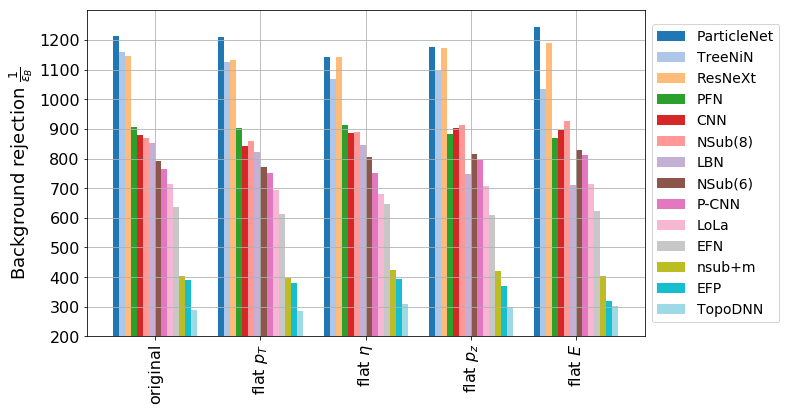

In [79]:
import pandas
from itertools import cycle, islice

plt.rcParams['figure.figsize'] = 10, 6

index = taggers_dict['names']
df = pd.DataFrame({'original': taggers_dict['crop_bg_reject'], r' flat $p_T$':taggers_dict['pT_flatten_bg_reject'], r' flat $\eta$':taggers_dict['eta_flatten_bg_reject'], r' flat $p_z$':taggers_dict['pz_flatten_bg_reject'] , r' flat $E$ ':taggers_dict['energy_flatten_bg_reject']}, index=index)

#Transpose
df=df.T

my_colors = list(islice(cycle(['teal', 'lightblue','coral', 'khaki',  'silver']), None, len(df)))
ax = df.plot(kind='bar', width=0.8,grid=True,yticks=np.arange(0,1300,100),ylim=[200,1300], xlim=[0,10], colormap='tab20', yerr=None)
ax.set(ylabel=r"Background rejection $\frac{1}{\epsilon_B}$")
lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('plot_bar_flatten.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

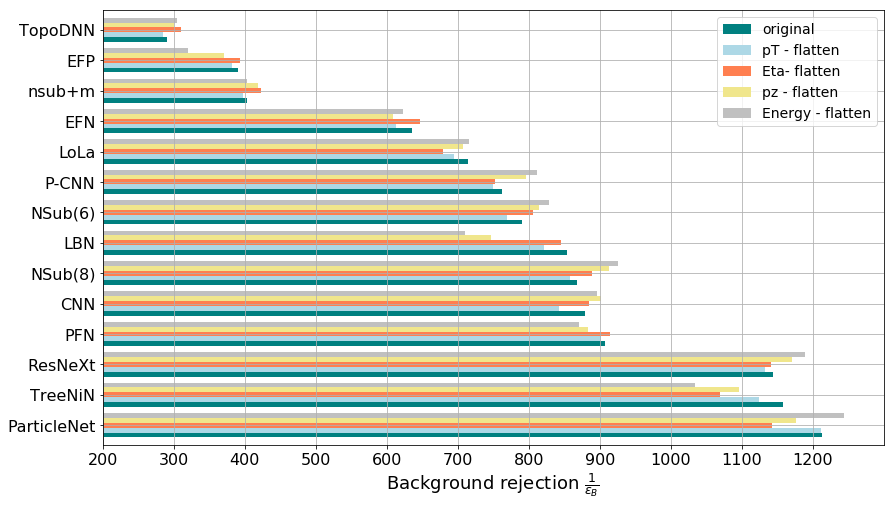

In [80]:
import pandas
from itertools import cycle, islice

plt.rcParams['figure.figsize'] = 14, 8

index = taggers_dict['names']
df = pd.DataFrame({'original': taggers_dict['crop_bg_reject'], 'pT - flatten':taggers_dict['pT_flatten_bg_reject'], 'Eta- flatten':taggers_dict['eta_flatten_bg_reject'], 'pz - flatten':taggers_dict['pz_flatten_bg_reject'] , 'Energy - flatten':taggers_dict['energy_flatten_bg_reject']}, index=index)

# my_colors = list(islice(cycle(['green','khaki', 'coral', 'turquoise', 'silver']), None, len(df)))
# my_colors = list(islice(cycle(['teal', 'lightblue','coral', 'khaki',  'silver']), None, len(df)))

my_colors = list(islice(cycle(['teal', 'lightblue','coral', 'khaki',  'silver']), None, len(df)))
ax = df.plot(kind='barh', width=0.8,grid=True,xticks=np.arange(0,1300,100),xlim=[200,1300],  color=my_colors)
ax.set(xlabel=r"Background rejection $\frac{1}{\epsilon_B}$")
plt.savefig('plot_hbar_flatten.pdf')

# Save and view dictionary with all the results

In [81]:
if save_results:
    with open('taggers_dict.pkl', "wb") as f: pickle.dump(taggers_dict, f)

In [82]:
#Load taggers_dict
with open('taggers_dict.pkl', "rb") as f: taggers_dict=pickle.load(f)

### taggers_dict: (dictionary with information for the whole analysis)

In [83]:
taggers_dict

{'names': ['ParticleNet',
  'TreeNiN',
  'ResNeXt',
  'PFN',
  'CNN',
  'NSub(8)',
  'LBN',
  'NSub(6)',
  'P-CNN',
  'LoLa',
  'EFN',
  'nsub+m',
  'EFP',
  'TopoDNN'],
 'out_prob': [array([[1.1010513e-06, 4.8343535e-03, 3.1652921e-04, ..., 9.9957770e-01,
          9.9292105e-01, 6.7949975e-01],
         [1.6902222e-05, 5.9984652e-03, 1.7527063e-04, ..., 9.9971682e-01,
          9.8456824e-01, 7.5414884e-01],
         [3.8767146e-07, 3.9316053e-03, 2.5973289e-04, ..., 9.9985564e-01,
          9.9075365e-01, 6.9107574e-01],
         ...,
         [8.3675599e-07, 2.9515319e-03, 1.7553489e-04, ..., 9.9972326e-01,
          9.7994393e-01, 6.4567071e-01],
         [5.5570113e-09, 4.8086871e-03, 4.5788405e-04, ..., 9.9931848e-01,
          9.9510252e-01, 7.7134007e-01],
         [6.1967121e-06, 5.6431871e-03, 1.9921106e-04, ..., 9.9975175e-01,
          9.8749417e-01, 7.0073730e-01]], dtype=float32),
  array([[1.46590683e-04, 3.86138149e-02, 1.07655046e-03, ...,
          9.99667048e-01, 9.